# Generative Model Development

### Team Mandrill Rumps - Solomon Barkley, Victoria Hwang, Anna B. Stephenson

April 11, 2017

Updated May 3, 2017

In [1]:
%matplotlib inline
import infer_structcol as ifs
import time
import os
from matplotlib import pyplot as plt
import seaborn as sns

The goal of this package is to infer the volume fraction of a colloidal structural color sample from its reflectance and/or transmittance spectrum. The generative model must be able to reproduce experimental reflectance and/or transmittance spectra from a set of parameters defining the sample. The foundation of the generative model is a stochastic multiple scattering algorithm included in a separate python package at https://github.com/manoharan-lab/structural-color. Here, we describe the multiple scattering model, our generative model (and its uncertainties), and our likelihood function.

### Monte Carlo multiple scattering calculations
These calculations are a part of the structural-color package (see above).

This model predicts the reflectance and transmittance spectra of structurally colored samples of thin films made from nanoscale spheres in a disordered packing. Past models have accounted for only a single scattering event in the sample [1], but this model uses a Monte Carlo approach to account for many scattering events, leading to more accurate results. 

The multiple scattering model simulates the trajectories of individual photons as random walkers that move through a material by sampling both the step size and the direction from distributions that are calculated using the material parameters. 

##### Material parameters

1. Particle size: the radius of the particles in the sample
2. Particle refractive index
3. Particle volume fraction 
4. Sample thickness
5. Matrix refractive index: the matrix is the material in which the particles are embedded
6. Medium refractive index: the medium is the material surrounding the the matrix/particle system, usually air

##### Procedure

1. A user-specified number of photon packets is created with an initial position, direction of propagation, and weight.
2. The photon packets travel a step size sampled from a distribution based on Beer's law [2], and the positions are updated. 
3. The photon packet weights are updated to account for the light absorbed during the step.
4. The photon packets are scattered after traveling the initial step, and new directions are sampled from the phase function, which is the angular distribution of the scattered intensity [3].
5. The step size is then sampled again and the process of scattering and stepping is repeated many times as specified by the user.
6. After the simulation is completed, reflectance and transmittance are calculated by counting the photon packets that exit the sample in the backscattering and forward hemisphere respectively. 

##### Calculating reflectance and transmittance

Each simulation sends in a user-specified number of photon packets at the surface of the sample film. To calculate the reflectance, the number of photon packets that exit the sample through the backscattering hemisphere is divided by the total number of photon packets sent into the sample. Analogously, transmittance is calculated by dividing the number of photon packets that exit the sample through the forward hemisphere by the total number of packets sent into the sample. 

A sample consists of a infinitely wide film of a finite thickness. The code also accounts for reflections due to the index contrast at the interface using the Fresnel equations. Refraction of the backscattered light exiting the sample is calculated using Snell's law, so that the angle of photons exiting the sample can be tracked in case the user is only interested in collecting a certain angle range of light. 

### Generative model
The generative model involves corrections on the reflectance and/or transmittance spectrum produced by the calculations in the structural-color package (see above).

##### Basic generative model

The goal of the generative model is to calculate reflectance and transmittance spectra from structural color samples defined by a set of parameters. The multiple scattering model described above generates theoretical spectra but these spectra do not correspond to experimental measurements. The full generative model incorporates the multiple scattering calculations as well as additional factors to produce reflectance and transmittance spectra that resemble experimental data.

All of the arguments taken by the multiple scattering model can be reliably measured for typical samples, except for particle volume fraction $\phi$, which is included in the generative model as an inference parameter. The multiple scattering model returns theoretical reflectance and transmittance calculations, $R^t(\lambda, \phi)$ and $T^t(\lambda, \phi)$, where $\lambda$ is the light wavelength at which reflectance and transmittance are calculated. A spectrum $\left \{ R^t(\phi) \right \}$ or $\left \{ T^t(\phi) \right \}$ consists of a set of $R^t_i(\lambda_i, \phi)$ or $T^t_i(\lambda_i, \phi)$ values, where $\left \{ \lambda_i \right \}$ represents all wavelengths used to produce the spectrum.

The theoretical reflectance $R^t$ and transmittance $T^t$ must be transformed into a corrected reflectance $R^c$ and transmittance $T^c$ before it can be compared with experimental data. Frequently, not all of the incident light on a non-absorbing sample is recorded as being reflected or transmitted since some light is lost in the experimental system. Since the exact reasons for loss are not known, they cannot be accurately measured. Instead, we parameterize a constant loss level $l_0$ with a linear modulation by wavelength with strength $l_1$, so that total losses $L_i = l_0 + l_1\lambda_i$. Therefore corrected spectra $\left \{ R^c(\phi) \right \}$ and $\left \{ T^c(\phi) \right \}$ are given by the elementwise product of $\left \{ R^t\left(\phi\right) \right \}$ or $\left \{ T^t\left(\phi\right) \right \}$ and $\left \{ 1-L_i \right \}$, or:

$$
R^c_i(\lambda_i,\phi, l_{0,r}, l_{1,r})=(1-l_{0,r}-l_{1,r}\lambda_i)\,R^t_i\left(\lambda_i, \phi\right)
$$

$$
T^c_i(\lambda_i,\phi, l_{0,t}, l_{1,t})=(1-l_{0,t}-l_{1,t}\lambda_i)\,T^t_i\left(\lambda_i, \phi\right)
$$

The $l_{0,r}$, $l_{1,r}$, $l_{0,t}$ and $l_{1,t}$ values are not generally known (or physically interesting), so they are marginalized over in the inference calculation (performed with MCMC so marginalization is trivial). Also, note that the loss parameters are different for reflectance and transmittance. 

##### Generative model extensions

There are ways to extend the model described above. A potential extension involves increasing the amount of information that goes into the multiple scattering calculation by allowing parameters to vary that are currently held fixed. Examples include sphere polydispersity and incident beam divergence, both of which are currently fixed at zero. Both values could be measured experimentally or sampled as parameters and marginalized over in an inference calculation. This would help to make the generative model more physical by accounting for phenomena that are currently neglected. They would require relatively minor changes to the multiple scattering code, but the generative model may need to be reworked for computation time concerns. The basic model includes only a single parameter ($\phi$) that affects the Monte Carlo output, but addition of more parameters would increase the dimensionality and computation time required to adequately sample parameter space.

### Model uncertainties

Due to the stochastic nature of the multiple scattering model, a calculated spectrum has uncertainties that must be included and propagated in the generative model. In general, these uncertainties will depend on the number of trajectories and scattering events we choose for a single calculation, and on the total number of runs we perform. 

The choice of the number of scattering events is determined by the "equilibration" time for the scattering calculations. This means that we need enough scattering events such that most of the photons exit the sample, which would resemble more closely the behavior of light in an experimental measurement. We decided to choose 100 scattering events for our calculations.

The number of trajectories will affect the noise level and reproducibility of the resulting spectra. The more trajectories we use, the less noisy and more reproducible the data. From previous calculations, we found that choosing 10,000 trajectories leads to very reproducible results; however, we also want to reduce the computation time of each run such that the later inference calculations are computationally accessible. Therefore, we decided to use 300 trajectories per run. The uncertainty range (set to 1 standard deviation) across the spectrum of visible wavelengths calculated from 100 of these runs is

$$
0.015 < \sigma < 0.032
$$

This range should be smaller than the measured uncertainties from the experimental data. 

### Likelihood Function

Due to computation time concerns, we hope to calculate theoretical spectra as few times as possible. Our basic likelihood function will therefore accept pre-calculated theoretical spectra for a given volume fraction $\left \{ R^t(\phi) \right \}$ and $\left \{ T^t(\phi) \right \}$. The pre-calculated theoretical spectra performs its own random walk (in volume fraction dimension only) following a Monte Carlo procedure. There are uncertainties associated with both the stochastic multiple scattering model and the experimental data. These two uncertainties are assumed to be Gaussian, and so their convolution is a Gaussian with variance equal to the sum of the two independent noise source variances [4]. In the approximation of a linear model, likelihood is proportional to $\exp{\left(-\chi^2/2\right)}$. The likelihood is a product over all wavelengths $\lambda_i$, and depends on the experimental reflectance $\{D_i\}$ with uncertainties $\{\sigma_{di}\}$, theoretical reflectance $\{R_i^t\}$ with uncertainties $\{\sigma_{ti}\}$, and Loss parameters $\{l_i\}$:

$$
p\left(D|M,\phi,l_0,l_1,I\right)=\left(2\pi\right)^{-N/2}\left[\prod_{i=1} ^N \left(\sigma_{di}^2+\sigma_{ti}^2\right)^{-1/2}\right]\exp{\left[\sum_{i=1}^N\frac{-\left(D_i-(1-l_0-l_1\lambda_i)R_i^t(\lambda_i,\phi)\right)^2}{2\left(\sigma_{di}^2+\sigma_{ti}^2\right)}\right]}
$$

### Choice of priors

The prior for the volume fraction is given by previous knowledge of the experimental system. Structurally-colored samples are made of packings of spherical particles. The highest theoretical packing for spheres is 74%, which corresponds to face-centered cubic (fcc) or hexagonal closed-packed (hcp) crystal structures. Since the samples of interest in this model are amorphous, their volume fraction will always be less than 0.74 [5]. On the other hand, the samples exhibit structural color, which require some degree of packing. Experimentally, samples that have a volume fraction lower than 0.35 do not show noticeable structural color peaks in their reflection spectra. Therefore, the prior for the volume fraction is given by:

$$
0.35 < \mathrm{volume \, fraction} < 0.74
$$

The prior for the losses is chosen based on the fact that the losses must be within the same range of possible values as the reflectance. A negative loss or a loss that is larger than 100% is not physically feasible. Thus, the prior is given by:

$$
0 < l_0 < 1 \\
0 < l_0 + l_1 < 1
$$

In [7]:
def calc_likelihood(spect1, spect2):
    '''
    Returns likelihood of obtaining an experimental dataset from a given theoretical spectrum

    Parameters
    -------
    spect1: Spectrum object
        experimental dataset
    spect2: Spectrum object
        calculated dataset
    '''
    resid_spect = calc_resid_spect(spect1, spect2)
    chi_square = 0.
    prefactor = 1.

    if 'reflectance' in spect1.keys():
        chi_square += np.sum(resid_spect.reflectance**2/resid_spect.sigma_r**2)
        prefactor *= 1/np.prod(resid_spect.sigma_r * np.sqrt(2*np.pi))

    if 'transmittance' in spect1.keys():
        chi_square += np.sum(resid_spect.transmittance**2/resid_spect.sigma_t**2)
        prefactor *= 1/np.prod(resid_spect.sigma_t * np.sqrt(2*np.pi))

    return prefactor * np.exp(-chi_square/2)

### Application

Computation of a spectrum with our generative model can take a long time due to the many calculations required in the multiple scattering algorithm. Here we present the steps to load in a simulated dataset and perform inference with a small number of walkers and steps using simulated reflectance data only. 

The simulated data has volume fraction $\phi = 0.59$, and losses $l_0=l_1=0$. It was generated by a single run of the multiple scattering code. We perform a basic MCMC computation with 6 walkers each taking 50 steps. This is not nearly sufficient to achieve a representative sampling of parameter values or even to 'burn-in', so the output will be highly dependent on the initial parameter distributions. 

We show traces of each parameter, as well as the log-probability over the walkers' trajectories. The traces are not particularly informative for such a small number of short trajectories. The main takeaway is that the walkers have not equilibrated over 50 steps (most visible in the plots of $l_0$ and $\log(p)$), and so the sparse distributions obtained do not truly represent the posterior probability. For this reason, we do not report most probable values from this calculation, since they would not be physically meaningful.

In [6]:
#convert test data into a spectrum file and load it
directory= os.path.join(os.getcwd(), 'infer_structcol', 'tests', 'test_data', 'simulated_data', 'reflection')
ifs.convert_data([450,500,550,600,650,700,750,800], 'ref.txt', 'dark.txt', directory)
spect = ifs.load_spectrum(refl_filepath = os.path.join(directory , 'converted', '0_data_file.txt'))

#define sample values
samp = ifs.Sample(spect.wavelength, particle_radius=119, thickness=120, particle_index=1.59, matrix_index=1)

#perform inference calculation
t0 = time.time()
walkers = ifs.run_mcmc(spect, samp, nwalkers=6, nsteps=10, seed=2)
print(time.time() - t0)

58.12645101547241


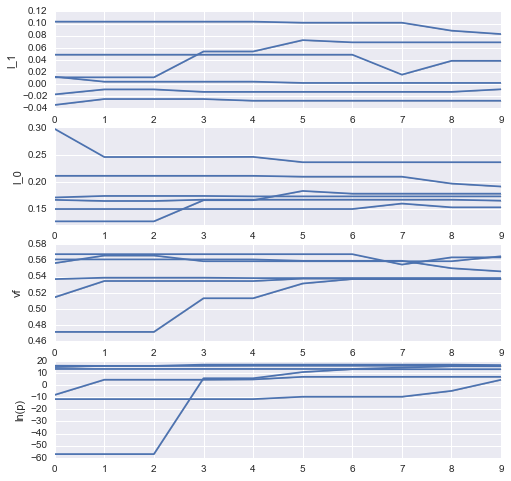

In [8]:
#code to visualize traces modified from notebook_week_09.ipynb
fig, (ax_l1, ax_l0, ax_vf, ax_lnprob) = plt.subplots(4, figsize=(8,8))
ax_vf.set(ylabel='vf')
ax_l0.set(ylabel='l_0')
ax_l1.set(ylabel='l_1')
ax_lnprob.set(ylabel='ln(p)')
#ax_lnprob.set(ylim=[0,20])
for i in range(6):
    sns.tsplot(walkers.chain[i,:,0], ax=ax_vf)
    sns.tsplot(walkers.chain[i,:,1], ax=ax_l0)
    sns.tsplot(walkers.chain[i,:,2], ax=ax_l1)
    sns.tsplot(walkers.lnprobability[i,:], ax=ax_lnprob)
plt.show()

### References

1. S. Magkiriadou, J. G. Park, Y. S. Kim, V. N. Manoharan (2014). “On the Absence of Red Structural Color in Photonic Glasses, Bird Feathers, and Certain Beetles”. Phys. Rev. E, 90, 062302.
2. L. Wang, S. L. Jaques, L. Zheng (1995). MCML - Monte Carlo modeling of light transport in multi-layered tissues. Computer Methods and Programs in Biomedicine , 47, 131-146.
3. C. F. Bohren, D. R. Huffman (1983). Absorption and Scattering of Light by Small Particles. New York: Wiley.
4. P. Gregory (2010). Bayesian Logical Data Analysis for the Physical Sciences. New York: Cambridge University Press.
5. T. C. Hales (2002). "An overview of the Kepler conjecture". arXiv:math/9811071v2.